# Advanced Machine Learning
## Project 1 - Optimization Algorithms
### Authors: Bartosz Grabek, Izabela Telejko, Grzegorz Zbrzeżny

In [1]:
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn import preprocessing 
from statsmodels.stats.outliers_influence import variance_inflation_factor  
pd.set_option('display.max_columns', 500)
from pandas.api.types import is_object_dtype
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# Preprocessing

Function for calculating VIF (source: https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python)

In [2]:
def one_hot_encode(df):
    for column in df:
        if is_object_dtype(df[column]):
            dummies = pd.get_dummies(df[column], prefix=column)
            if np.sum(df[column].isna()) == 0:
                dummies = dummies.iloc[:, :-1]
            df = df = df.drop(column, axis = 1)
            df = df.join(dummies)
    return df

In [3]:
def calculate_vif(X, thresh=5.0):
    X = X.assign(const=1)  # faster than add_constant from statsmodels
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix) for ix in range(X.iloc[:, variables].shape[1])]
        vif = vif[:-1]  # don't let the constant be removed in the loop.
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables[:-1]])
    return X.iloc[:, variables[:-1]]

## Preprocessing functions

In [4]:
def preprocess_employee(filename):
    df = pd.read_csv(filename)
    df['EducationBachelors'] = 1 * (df['Education'] == 'Bachelors')
    df['EducationMasters'] = 1 * (df['Education'] == 'Masters')
    df['Gender'] = df['Gender'].map({'Female': 1, 'Male': 0})
    df['EverBenched'] = df['EverBenched'].map({'No': 0, 'Yes': 1})
    df.drop(['Education', 'City'], axis=1, inplace=True)
    X = calculate_vif(df.drop('LeaveOrNot', axis=1)).to_numpy()
    y = df['LeaveOrNot'].to_numpy()
    return X, np.expand_dims(y, 1)

def preprocess_challenger(filename):
    df = pd.read_csv(filename)
    df.drop('gameId', axis=1, inplace=True)
    for col in ['blue', 'red']:
        for lane in ['BOT_LANE', 'MID_LANE', 'TOP_LANE']:
            df[f'{col}FirstTowerLane_{lane}'] = df[f'{col}FirstTowerLane'].apply(lambda x: int(lane in x))
        for dragon in ['AIR_DRAGON', 'WATER_DRAGON', 'FIRE_DRAGON', 'EARTH_DRAGON']:
            df[f'{col}DragnoType_{dragon}'] = df[f'{col}DragnoType'].apply(lambda x: int(lane in x))
        df.drop(f'{col}FirstTowerLane', axis=1, inplace=True)
        df.drop(f'{col}DragnoType', axis=1, inplace=True)
    X = calculate_vif(df.drop('blueWins', axis=1)).to_numpy()
    y = df['blueWins'].to_numpy()
    return X, np.expand_dims(y, 1)

def preprocess_jungle(filename):
    df = arff.loadarff(filename)
    df = pd.DataFrame(df[0])
    str_df = df.select_dtypes([object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    for col in str_df:
        df[col] = str_df[col]
    df = df[df['class'] != 'd']
    df[['highest_strength', 'closest_to_den', 'fastest_to_den', 'class']] = df.copy()[['highest_strength', 'closest_to_den', 'fastest_to_den', 'class']].applymap(lambda x: int(x == 'w'))
    df = pd.concat([df, pd.get_dummies(df[['white_piece0_advanced', 'black_piece0_advanced']], drop_first=True)], axis=1)
    df.drop(['white_piece0_advanced', 'black_piece0_advanced'], axis=1, inplace=True)
    df = df.apply(pd.to_numeric)
    X = calculate_vif(df.drop('class', axis=1)).to_numpy()
    y = df['class'].to_numpy()
    return X, np.expand_dims(y, 1)

def preprocess_water(filename):
    water = pd.read_csv(filename)
    water["ammonia"] = water["ammonia"].replace("#NUM!", -100)
    water["ammonia"] = water["ammonia"].astype(float)
    water["ammonia"] = water["ammonia"].replace(-100, water.loc[water["ammonia"] != -100, "ammonia"].mean())
    
    water["is_safe"] = water["is_safe"].replace("#NUM!", -100)
    water["is_safe"] = water["is_safe"].astype(int)
    if np.mean( water.loc[water["is_safe"] != -100, "is_safe"]) > 0.5:
        dominant = 1
    else:
        dominant = 0
    water["is_safe"] = water["is_safe"].replace(-100, dominant)
    y_water = water.is_safe.to_numpy()
    X_water = water.drop("is_safe", axis=1)
    X_water = calculate_vif(X_water).to_numpy()
    return X_water, np.expand_dims(y_water, 1)

def preprocess_booking(filename):
    booking = pd.read_csv(filename).drop(["Booking_ID", "date of reservation"], axis=1)
    booking["market segment type"] = 1*(booking["market segment type"] == "Online")
    booking["booking status"] = 1*(booking["booking status"] == "Canceled")
    label_encoder = preprocessing.LabelEncoder() 
    booking["room type"] = label_encoder.fit_transform(booking["room type"]) 
    booking = one_hot_encode(booking)
    y_booking = booking["booking status"].to_numpy()
    X_booking = booking.drop("booking status", axis=1)
    X_booking = calculate_vif(X_booking).to_numpy()
    return X_booking, np.expand_dims(y_booking, 1)

def preprocess_churn(filename):
    churn = pd.read_csv(filename)
    churn["FrequentFlyer"] = 1*(churn["FrequentFlyer"] == "Yes")
    churn["BookedHotelOrNot"] = 1*(churn["BookedHotelOrNot"] == "Yes")
    churn["AccountSyncedToSocialMedia"] = 1*(churn["AccountSyncedToSocialMedia"] == "Yes")
    churn.loc[churn["AnnualIncomeClass"] == "Low Income", "AnnualIncomeClass"] = 0
    churn.loc[churn["AnnualIncomeClass"] == "Middle Income", "AnnualIncomeClass"] = 1
    churn.loc[churn["AnnualIncomeClass"] == "High Income", "AnnualIncomeClass"] = 2
    churn.AnnualIncomeClass = churn.AnnualIncomeClass.astype(int)
    y_churn = churn.Target.to_numpy()
    X_churn = churn.drop("Target", axis=1)
    X_churn = calculate_vif(X_churn).to_numpy()
    return X_churn, np.expand_dims(y_churn, 1)

### TODO:
Some columns in X_challenger and X_jungle have only 0 values

In [5]:
X_employee, y_employee = preprocess_employee('data/employee.csv')
X_challenger, y_challenger = preprocess_challenger('data/challenger_lol.csv')
X_jungle, y_jungle = preprocess_jungle('data/jungle_chess.arff')
X_water, y_water = preprocess_water("data/water_quality.csv")
X_booking, y_booking = preprocess_booking("data/booking.csv")
X_churn, y_churn = preprocess_churn("data/churn.csv")

Remaining variables:
Index(['JoiningYear', 'PaymentTier', 'Age', 'Gender', 'EverBenched',
       'ExperienceInCurrentDomain', 'EducationBachelors', 'EducationMasters'],
      dtype='object')
dropping 'blueTotalLevel' at index: 2
dropping 'blueKill' at index: 6
dropping 'blueDeath' at index: 6
dropping 'blueFirstTower' at index: 9
dropping 'blueTowerKills' at index: 10
dropping 'redTotalLevel' at index: 20
dropping 'redFirstTower' at index: 29
dropping 'redTowerKills' at index: 30
dropping 'blueTotalGolds' at index: 0
dropping 'redAvgLevel' at index: 19
dropping 'redTotalGolds' at index: 17
dropping 'redFirstDragon' at index: 31
dropping 'blueAssist' at index: 5
dropping 'redAssist' at index: 22
dropping 'blueFirstInhibitor' at index: 7
dropping 'redFirstInhibitor' at index: 23
dropping 'blueTotalMinionKills' at index: 2
dropping 'redDeath' at index: 19
Remaining variables:
Index(['blueCurrentGolds', 'blueAvgLevel', 'blueTotalJungleMinionKills',
       'blueFirstBlood', 'blueWardPlaced'

In [33]:
def log_likelihood(X, y, beta):
    return -np.sum(X @ beta * y - np.log(1 + np.exp(X @ beta))) 

def calc_pi(X, beta):
    exp = np.exp(X @ beta)
    return exp / (1 + exp)

def accuracy(true, pred):
    return np.sum(1 - abs(true - pred)) / true.shape[0]

In [486]:
def IWLS(X, y, n_iter=10, print_likeli=True):
#     X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    # beta = np.zeros((X.shape[1], 1))
    pi = calc_pi(X, beta)
    l_prev = log_likelihood(X, y, beta)
#     if print_likeli:
#         print(f"Starting Log likelihood is: {l_prev}")
    l_vals = [l_prev]
    for i in tqdm(range(n_iter), "Iterations"):
        W = np.diag((pi * (1 - pi)).T[0])
        beta = beta + np.linalg.inv(X.T @ W @ X) @ X.T @ (y - pi)
        pi = calc_pi(X, beta)
        l = log_likelihood(X, y, beta)
        l_diff = abs(l - l_prev)
        l_prev = l
#         if print_likeli:
#             print(f"Log likelihood is: {l}")
        l_vals.append(l)
#         if l_diff < 1:
#             break
    
    return l_vals, beta, 1*(pi > 0.5)

In [491]:
def GD(
        X, 
        Y, 
        learning_rate, 
        n_epoch=1, 
        batch_size=1, 
        print_every=50, 
        print_likeli=True, 
        use_adam=True,
        beta1 = 0.9,
        beta2 = 0.999
    ):
    """
    Stochastic Gradient Descent with logistic loss for binary classification [0,1].
    Print the loss values at interval of your choice.

    Arguments:
    X : Data matrix
    Y : Labels
    W : Weights, previously initialized outside the function
    learning_rate : Float value of step size to take.
    n_epoch : Maximum number of epochs, after which to stop
    batch_size : Size of the batch to use for each iteration
    print_every : if positive prints loss after every `record_every` iteration
                  (1=record all losses), otherwise record nothing

    Returns:
    history : A list containing the loss value at each iteration
    best_w : The best weights corresponding to the best loss value
    """
    def make_batches(X, y, batch_size):
        perm = np.random.permutation(len(y))
        X_perm = X[perm, :]
        y_perm = y[perm]
        return np.array_split(X_perm, int(X_perm.shape[0]/batch_size)), np.array_split(y_perm, int(len(y_perm)/batch_size))
    
    def sigmoid(z):
        """
        Sigmoid activation function.

        Arguments:
        z : Input scalar or batch of scalars

        Returns:
        activation : Sigmoid activation(s) on z
        """
        activation = 1 / (1 + np.exp(-z))
        return activation

    def logistic_loss(preds, targets):
        """
        Logistic loss function for binary classification.

        Arguments:
        preds : Predicted values
        targets : Target values

        Returns :
        cost : The mean logistic loss value between preds and targets
        """
        # mean logistic loss
        eps = 1e-14
        y = targets
        y_hat = preds
        cost = np.mean(-y*np.log(y_hat+eps)-(1-y)*np.log(1-y_hat+eps))
        return cost

    def dlogistic(preds, X, Y, W=[]):
        """
        Gradient/derivative of the logistic loss.

        Arguments:
        preds : Predicted values
        X : Input data matrix
        Y : True target values
        W : The weights, optional argument, may/may not be needed depending on the loss function
        """
        y_pred = sigmoid(np.dot(W, X.T))
        J = X.T @ (np.expand_dims(y_pred, 1)-Y)
        
        J = np.mean(J, axis=1)
        return J

    history = []  # to keep track of loss values
    X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
#     w_init = np.ones(X.shape[1])
    w_init = (np.linalg.inv(X.T @ X) @ X.T @ y).T[0]
    best_w = w_init.copy()
    n_samples = X.shape[0]
    log_like = log_likelihood(X, y, np.expand_dims(best_w, 1))
    history.append(log_like)
    
    #ADAM initialization
    M = np.zeros(len(w_init))
    R = np.zeros(len(w_init))
    t = 0
    eps = 1e-8
    
#     if print_likeli:
#         print("Minus log likelihood", log_like)
    for i in tqdm(range(n_epoch), "Epochs"):
        batches = make_batches(X, y, batch_size)
        for j in range(len(batches[0])):
            t += 1
            X_sample = batches[0][j]
            Y_sample = batches[1][j]

            # compute y_hat (preds) and then loss (L)
            # sigmoid, probability of class 1
            preds = 1 / (1 + np.exp(-np.dot(best_w, X_sample.T)))

            # compute loss gradient (J) and update weights
            J = dlogistic(preds, X_sample, Y_sample, W=best_w)
            if use_adam:
                M = beta1 * M + (1 - beta1) * J
                R = beta2 * R + (1 - beta2) * (J**2)

                M_bias = M / (1 - beta1**t)
                R_bias = R / (1 - beta2**t)

                best_w = best_w - learning_rate * (M_bias / np.sqrt(R_bias + eps))
            else:
                best_w = best_w - learning_rate*J
        log_like = log_likelihood(X, y, np.expand_dims(best_w, 1))
        history.append(log_like)
#         if print_likeli:
#             print("Minus log likelihood", log_like)
    pi = X @ best_w
    return history, best_w, 1*(np.expand_dims(pi, 1) > 0.5)

## Input data

In [506]:
X, y = X_churn, y_churn

## IWLS

In [507]:
l_iwls_vals, best_beta_iwls, best_iwls_preds = IWLS(X, y, n_iter=100)

Iterations: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 227.78it/s]


## Stochastic Gradient Descend

In [508]:
l_sgd_vals, best_beta_gd, best_sgd_preds = GD(X, y, 0.0002, n_epoch=100, use_adam=False)

Epochs: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.54it/s]


## SDA with ADAM optimization

In [509]:
l_adam_vals, best_beta_adam, best_adam_preds = GD(X, y, 0.0002, n_epoch=100)

Epochs: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.39it/s]


In [510]:
gd_acc = balanced_accuracy_score(y, best_sgd_preds)
iwls_acc = balanced_accuracy_score(y, best_iwls_preds)
adam_acc = balanced_accuracy_score(y, best_adam_preds)

# model = LogisticRegression(penalty="none")
model = LogisticRegression()
model.fit(X, y.T[0])
model_preds = model.predict(X)
scikit_acc = balanced_accuracy_score(y, np.expand_dims(model_preds, 1))

In [511]:
print(f"Balanced accuracy of GD without optimizer is: {gd_acc}")
print(f"Balanced accuracy of SGD with ADAM is: {adam_acc}")
print(f"Balanced accuracy of IWLS is: {iwls_acc}")
print(f"Balanced accuracy of LR from Scikit is {scikit_acc}")

Balanced accuracy of GD without optimizer is: 0.5015472113502936
Balanced accuracy of SGD with ADAM is: 0.6008255870841488
Balanced accuracy of IWLS is: 0.6743823385518591
Balanced accuracy of LR from Scikit is 0.6697407045009784


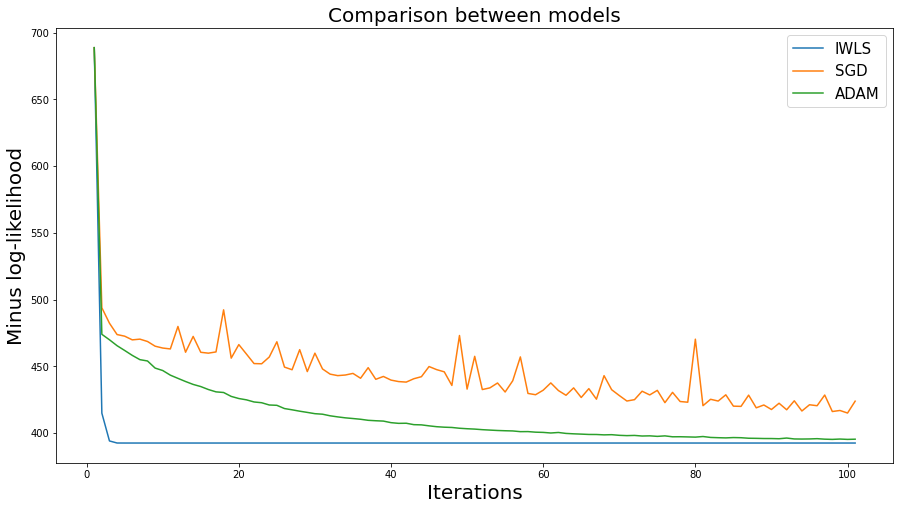

In [513]:
plt.figure(figsize=(15, 8))
plt.plot(np.linspace(1, len(l_iwls_vals), len(l_iwls_vals)), l_iwls_vals, label="IWLS")
plt.plot(np.linspace(1, len(l_sgd_vals), len(l_sgd_vals)), l_sgd_vals, label="SGD")
plt.plot(np.linspace(1, len(l_adam_vals), len(l_adam_vals)), l_adam_vals, label="ADAM")
plt.legend()
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=15)
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Minus log-likelihood", fontsize=20)
plt.title("Comparison between models", fontsize=20)
plt.show()

### Data generated from logistic model

In [500]:
beta1 = 2

n1 = 1000
x1 = np.random.exponential(1, size=n1)

n2 = 1000
x2 = np.random.exponential(1/(beta1+1), size=n2)

X = np.expand_dims(np.concatenate((x1, x2), axis=0), axis=1)
y = np.expand_dims(np.concatenate((np.ones((1, n1)), np.zeros((1, n2))), axis=1)[0], 1)

In [501]:
pi = n1 / (n1 + n2)
b0 = -np.log((1 + beta1) * ((1-pi)/pi))

In [502]:
l_iwls_vals, best_beta_iwls, best_iwls_preds = IWLS(X, y, n_iter=100, print_likeli=False)
l_sgd_vals, best_beta_gd, best_sgd_preds = GD(X, y, 0.0002, n_epoch=200, print_likeli=False, use_adam=False)
l_adam_vals, best_beta_adam, best_adam_preds = GD(X, y, 0.0002, n_epoch=200, print_likeli=False)

Epochs: 100%|████████████████████████████████████████████████████████████████████████| 200/200 [00:24<00:00,  8.01it/s]


In [503]:
print(f"Theoretical betas: b0: {b0}, b1: {beta1}" )
print(f"Empirical betas for SGD without optimizers: b0: {best_beta_gd[0]}, b1: {best_beta_gd[1]}")
print(f"Empirical betas for SGD with ADAM: b0: {best_beta_adam[0]}, b1: {best_beta_adam[1]}")
print(f"Empirical betas for IWLS: b0: {best_beta_iwls[0][0]}, b1: {best_beta_iwls[1][0]}")

Theoretical betas: b0: -1.0986122886681098, b1: 2
Empirical betas for SGD without optimizers: b0: -1.1110910633473996, b1: 1.9470987003455906
Empirical betas for SGD with ADAM: b0: -1.2054752926001877, b1: 2.116966060034407
Empirical betas for IWLS: b0: -1.2014203715520715, b1: 2.113029607348644
